### Group Members name


1. Armandine Sorel Kouyim Meli
2. Samuael Adnew
3. Verlon Roel Mbingui 



# Independent Component Analysis(ICA)


### Generative model of ICA
$$ x=AS $$

### Unmixing matrix(inverse of mixing matrix)
$$ W=A^{-1}$$


#### Predicting the original source using the recorded or observed data, x, and estimated unmixing matrix, W, to predict the sources
$$ S=Wx $$

#### The goal is to estimate the optimal W, the unmixing matrix.

### Sigmoid
$$g(S_j)=\dfrac{1}{1+\exp(-S_j)}\quad \text{with} \quad S_j = w_j^{T}x$$

### Derivative of sigmoid
$$ g'(S_j)=g(S_j)(1-g(S_j)) $$
### Log likelihood
\begin{equation}
L(w) =  \sum_{i=1}^{n}\left( \left(\sum_{j=1}^{d}\log(g'(S_j))\right) +\log(\vert W\vert)\right)
\label{1}
\end{equation}

### Gradient of Log Likelihood
\begin{equation}
 \nabla_{w}L(w)=\sum_{i=1}^{n}\left( (1-2g(w_{j}^{T}x^{(i)})x^{(i)T}+(W^{T})^{-1} \right) ~~ \text{where} ~~ S_j^{(i)} = w_j^{T}x^{(i)}.
\label{2}
\end{equation}

### Update unmixing matrix with stochastic gradient ascent
$$
   W := W + \alpha  \begin{pmatrix}  \begin{bmatrix} 
         1-2g(w_{1}^{T}x^{(i)})\\1-2g(w_{2}^{T}x^{(i)})\\ \vdots \\1-2g(w_{d}^{T}x^{(i)}) 
   \end{bmatrix} x^{(i)T}+(W^{T})^{-1}\end{pmatrix}
$$


In [2]:
import librosa
import numpy as np
import IPython.display as disp
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms

### Loading MNIST dataset
We require this data to perform a mixing operation on the simple image files of the dataset, and try to recover the original data using Independent Component Analysis(ICA)

In [3]:
dataset1 = torchvision.datasets.MNIST(root="./", train=True, transform= transforms.ToTensor(), download=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 145992384.45it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 21170166.69it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 49018977.05it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 6422969.92it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [4]:
train_loader = torch.utils.data.DataLoader(dataset=dataset1, batch_size=16)

itera = iter(train_loader)
example = next(itera)

#### ploting the original prictures before mixing

28
torch.Size([1, 28, 28])


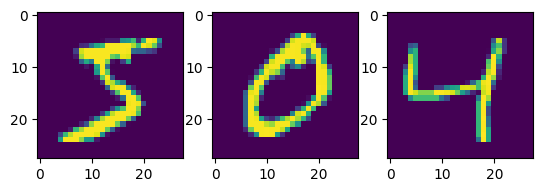

In [5]:
im1 = example[0][0]
print(len(example[0][0][0]))
print(im1.shape)

fig, axes = plt.subplots(1, 3)
axes[0].imshow(example[0][0][0])
axes[1].imshow(example[0][1][0])
axes[2].imshow(example[0][2][0])

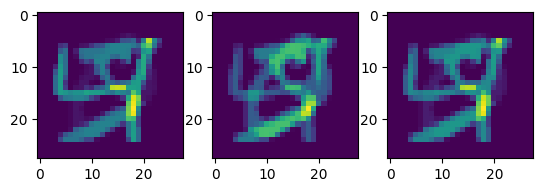

In [17]:
# Here a is our mixing matrix
# print(example[0][2][0].flatten(), len(example[0][2][0].flatten()))
imput_matrix = np.array([
    example[0][2][0].flatten().numpy(),
    example[0][0][0].flatten().numpy(),
    example[0][1][0].flatten().numpy()
]).reshape(3, 784)
n, d = imput_matrix.shape

A = np.random.rand(n, n)
newmixed= A@imput_matrix

fig, axes = plt.subplots(1, n)
axes[0].imshow(newmixed[0].reshape(28,28))
axes[1].imshow(newmixed[1].reshape(28,28))
axes[2].imshow(newmixed[2].reshape(28,28))

### Independent Component Analysis(ICA) model
We use this model to initialize variables, such as: learning rate, number of epoch, and unmixing matrix initialiation; So that we can use it while fitting or finding the unmixing matrix. And, perform a Gradient ascent using the gradient of maximum likelihood *** number of epochs *** times.

In [7]:
class ICA:
    def __init__(self, numberEpoch, learning_rate):
        self.numberEpoch= numberEpoch
        self.lr  = learning_rate
        self.weight = None
    
    def sigmoid(self, w, x):
        return 1/(1 + np.exp(-w@x))
    
    def dsigmoid(self, w, x):
        return self.sigmoid(w, x).T@(1-self.sigmoid(w, x))
    
    def likelihood_(self, w, x):
        if np.linalg.det(w) >0:
            return np.sum(np.log(self.dsigmoid(w, x)) + np.log(np.linalg.det(w)))
        else:
            return np.sum(np.sum(np.log(self.dsigmoid(w, x))))

    def grad_likelihood(self, w, x):
        try:
            return self.lr*((1-2*self.sigmoid(w, x))@x.T) + np.linalg.inv(w.T)
        except:
            return self.lr*((1-2*self.sigmoid(w, x))@x.T) + np.linalg.pinv(w.T)
         
    def fit(self, x, apply_mean= False):
        if apply_mean:
            mean = np.mean(x, axis=1)
            x -= mean[:, np.newaxis]
        n, d = x.shape
        self.weight = np.random.rand(n,n)
        likelihoods = []
        one_p=1
        if self.numberEpoch>100:
            one_p = int(self.numberEpoch*0.002)
        for epoch in range(self.numberEpoch):
            self.weight += self.grad_likelihood(self.weight, x)
            if epoch % one_p ==0:
                likelihoods.append(self.likelihood_(self.weight, x))
        return self.weight, likelihoods

<ipython-input-7-2001ba053a76>:8: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(-w@x))
<ipython-input-7-2001ba053a76>:15: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.dsigmoid(w, x)) + np.log(np.linalg.det(w)))
<ipython-input-7-2001ba053a76>:17: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.sum(np.log(self.dsigmoid(w, x))))


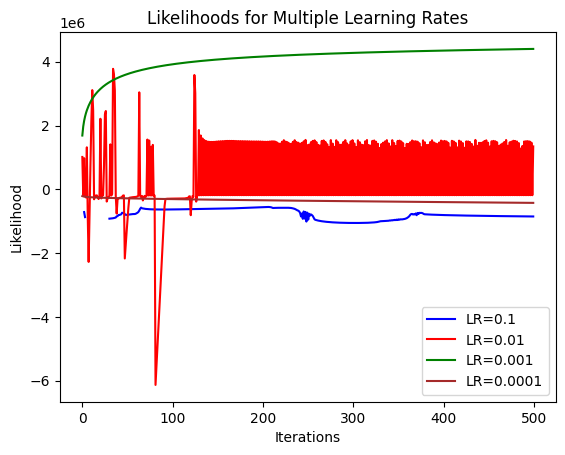

In [8]:
learning_rates=[0.1,0.01, 0.001, 0.0001]
colors = ['blue', 'red', 'green', "brown"]
fig, ax = plt.subplots()
weight = None
for i in range(len(learning_rates)):
  ica = ICA(1000, learning_rates[i])
  weight, likelihood = ica.fit(newmixed)
  ax.plot(np.arange(len(likelihood)), likelihood, color=colors[i], label='LR='+str(learning_rates[i]))

ax.set_title('Likelihoods for Multiple Learning Rates')
ax.set_xlabel('Iterations')
ax.set_ylabel('Likelihood')

ax.legend()

plt.show()

In [12]:
ica = ICA(10100, 0.001)
weight, likelihood = ica.fit(newmixed)
smatrix = weight@newmixed

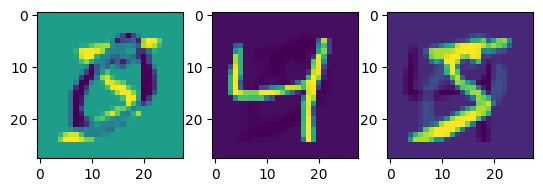

In [18]:
fig, axes = plt.subplots(1, 3)
axes[0].imshow(smatrix[0].reshape(28,28))
axes[1].imshow(smatrix[1].reshape(28,28))
axes[2].imshow(smatrix[2].reshape(28,28))

In [11]:
sami, sr = librosa.load("r1.wav")
sorel, srr = librosa.load("r2.wav")

<ipython-input-11-432641388b41>:1: UserWarning: PySoundFile failed. Trying audioread instead.
  sami, sr = librosa.load("r1.wav")
/usr/local/lib/python3.9/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


FileNotFoundError: ignored

In [ ]:
disp.Audio(sorel, rate=srr)

In [ ]:
disp.Audio(sami, rate=sr)

In [ ]:
original_voice = np.array([
    sami[:209113],
    sorel[:209113],
])

n_v, d_v = original_voice.shape

A = np.array([[1, 2], [2, 1]])

mixed_voice= A@original_voice

In [ ]:
disp.Audio(mixed_voice[0], rate=sr)

In [ ]:
disp.Audio(mixed_voice[1], rate=sr)

In [ ]:
ica = ICA(2, 0.001)

In [ ]:
new_weight, likelihood=ica.fit(mixed_voice, True)
s_separated= new_weight@mixed_voice

In [ ]:
disp.Audio(s_separated[0], rate=sr)

In [ ]:
disp.Audio(s_separated[1], rate=sr)

In [ ]:
import soundfile as sf

In [ ]:
sf.write("source_1.wav",s_separated[0],sr)
sf.write("source_2.wav",s_separated[1],sr)

In [ ]:

image1 = plt.imread("Tafesse.jpeg")
print(type(image1), image1.shape, image1.flatten().shape)

damo = plt.imread("debre-damo.jpeg")
print(type(damo), damo.shape, damo.flatten().shape)
a, axes=plt.subplots(1,2)
axes[0].imshow(damo[50:150, :150])
axes[1].imshow(image1[:100, :150])

In [ ]:
images = np.array([
    damo[50:150, :150].flatten(),
    image1[:100, :150].flatten(),
])

A = np.random.rand(2, 2)*10

mixed = A@images

print(mixed.shape)
reshaped = (mixed[0].copy()//20).astype(np.int32)
print(reshaped.shape)
reshaped= reshaped.reshape(100,150,3)
print(reshaped[0][0])

In [ ]:
plt.imshow(reshaped)

In [ ]:
ica_new = ICA(100, 0.001)

In [ ]:
w_matrix, likelihood = ica_new.fit(mixed, True)

In [ ]:
s_matrix=w_matrix@mixed
plt.imshow((s_matrix[1].astype(np.int64)*10).reshape(100,150,3))